In [122]:
import pandas as pd

df = pd.read_csv('EV_files/EV_train.csv')
labels = pd.read_csv('EV_files/EV_train_labels.csv')

In [123]:
df.head(3)

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233,0.351,0.194,0.292,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304,0.361,0.342,0.355,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125,0.088,0.106,0.094,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113


In [124]:
labels.head(3)

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's set House ID as our index.

In [125]:
df.set_index('House ID', inplace=True)
labels.set_index('House ID', inplace=True)

In [126]:
df.shape, labels.shape

((1590, 2880), (1590, 2880))

Smart meter power readings (in kW) from 1590 houses taken at half-hour intervals. 2880 measurements at half-hour intervals spans 60 days. Let's see if any houses have missing data.

In [127]:
houses_w_nans = df[pd.isnull(df).any(axis=1)]
houses_w_nans

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
House ID,,,,,,,,,,,,,,,,,,,,,
11637447,2.395,2.380,2.336,2.417,2.422,2.497,2.486,3.015,2.317,2.336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11635802,0.249,0.271,0.266,0.255,0.247,0.280,0.178,0.237,0.133,0.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11637232,1.218,1.087,0.995,0.791,0.798,0.756,0.745,0.736,0.699,0.691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11632700,0.113,0.106,0.113,0.150,0.119,0.106,0.100,0.144,0.144,0.106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 4 of 1590 houses. There look to be several 30-minute intervals in a row with missing data. I am not fond of imputing missing values of electricity data for extended periods of time, so let's drop these houses for now. In a production model, I'd probably impute NaN values with the mean of that house's half hour interval (i.e. calculate the mean kW usage at 1:00pm for a house and impute that value at a NaN happening at 1pm).

In [128]:
houses_missing_data = houses_w_nans.index.tolist()
houses_missing_data

[11637447, 11635802, 11637232, 11632700]

Let's drop these houses from our training set.

In [129]:
df = df[~df.index.isin(houses_missing_data)]
labels = labels[~labels.index.isin(houses_missing_data)]

In [130]:
df.shape, labels.shape

((1586, 2880), (1586, 2880))

We now only have a training set for houses with compelete meter data. Let's address the first problem:
1. Which residences have electric vehicles?

Before applying any models, I like to perform some basic feature engineering and run a few statistcs to get a sense of how the two classes differ. These engineered features may or may not be used in our model. Let's create a dataframe of engineered features called *X*.

In [131]:
X = df.mean(axis=1).rename('Pwr_Avg').to_frame()
X['Pwr_Med'] = df.median(axis=1)
X['Pwr_Rng'] = df.max(axis=1) - df.min(axis=1)
X['Pwr_Std'] = df.std(axis=1)
X['Pwr_IQR'] = df.quantile(q=0.75, axis=1) - df.quantile(q=0.25, axis=1)
X['Avg_Norm_Rng'] = X['Pwr_Rng'] / X['Pwr_Avg']
X['IQR_Norm'] = X['Pwr_IQR'] / X['Pwr_Avg']

In [132]:
X.head(3)

,Pwr_Avg,Pwr_Med,Pwr_Rng,Pwr_Std,Pwr_IQR,Avg_Norm_Rng,IQR_Norm
House ID,,,,,,,
11655099,0.569631,0.445,2.010,0.366291,0.44600,3.528601,0.782963
11633257,0.667629,0.465,3.710,0.489821,0.60425,5.556980,0.905069
11651552,0.659690,0.356,4.763,0.736209,0.86200,7.220055,1.306674


In [133]:
# create Has_EV label and join with X on House ID
ev_label = labels.max(axis=1).rename('Has_EV')
X = pd.concat((X, ev_label), axis=1, join='inner')

In [134]:
X.head(3)

,Pwr_Avg,Pwr_Med,Pwr_Rng,Pwr_Std,Pwr_IQR,Avg_Norm_Rng,IQR_Norm,Has_EV
House ID,,,,,,,,
11655099,0.569631,0.445,2.010,0.366291,0.44600,3.528601,0.782963,0
11633257,0.667629,0.465,3.710,0.489821,0.60425,5.556980,0.905069,0
11651552,0.659690,0.356,4.763,0.736209,0.86200,7.220055,1.306674,0


Let's divide up the data from into homes with EV's and homes without EV's and see if any of these engineered features are meaningful.

Once we have a set of features we're happy with, we can throw a machine learning model at it. Logistic regression will probably be a good place to start for interpretability and getting a sense of feature importance, although I've been on a gradient boosting kick lately so that is probably where I will end up. Gradient boosting is good at dealing with unbalanced data.

In [135]:
has_EV = X.loc[X['Has_EV'] == 1]
no_EV = X.loc[X['Has_EV'] == 0]

In [136]:
has_EV.describe().T

,count,mean,std,min,25%,50%,75%,max
Pwr_Avg,484.0,1.439297,4.077576,0.361415,0.757689,0.935727,1.267361,84.905235
Pwr_Med,484.0,1.062900,3.678616,0.003000,0.438000,0.627500,0.915250,75.832500
Pwr_Rng,484.0,6.932785,6.155856,2.269128,5.037619,6.327042,7.519634,112.191000
Pwr_Std,484.0,1.087139,1.131893,0.379857,0.764247,0.931562,1.127805,21.487303
Pwr_IQR,484.0,1.221299,1.502654,0.109000,0.642875,0.911440,1.302313,24.431936
Avg_Norm_Rng,484.0,6.353772,2.182650,1.214168,4.884267,6.203913,7.627869,15.211293
IQR_Norm,484.0,0.983917,0.380982,0.141754,0.727448,0.976659,1.237715,2.400726
Has_EV,484.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [137]:
no_EV.describe().T

,count,mean,std,min,25%,50%,75%,max
Pwr_Avg,1102.0,1.383729,2.559698,0.282908,0.611995,0.794658,1.177699,45.663464
Pwr_Med,1102.0,1.048280,2.373142,0.000000,0.400000,0.563500,0.904500,45.840000
Pwr_Rng,1102.0,4.811237,5.730188,0.071000,2.708000,3.596000,4.753750,69.824000
Pwr_Std,1102.0,0.933739,1.367692,0.011757,0.461507,0.639611,0.878859,19.064741
Pwr_IQR,1102.0,1.301223,2.111647,0.016000,0.576625,0.791625,1.228875,30.943500
Avg_Norm_Rng,1102.0,4.341502,1.639058,0.138400,3.285204,4.259859,5.340507,12.343324
IQR_Norm,1102.0,1.054969,0.457580,0.030782,0.760978,1.020498,1.302243,2.597722
Has_EV,1102.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Looks to be some significant differences. Let's train up a quick Random Forest, and see which features are important. Then run a quick grid search to establish a baseline comparitive model. I will be assessing models on F1 score which I found most appropriate for imbalanced classes.

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
np.random.seed(15)  # for reproducibility

best_rf = RandomForestClassifier(n_estimators=15, criterion='entropy',
                                     max_features='log2', max_depth=12,
                                     min_samples_leaf=2, min_samples_split=4,
                                     bootstrap=True, n_jobs=-1)

In [139]:
y = X.pop('Has_EV')
scores = cross_val_score(best_rf, X, y, cv=3, scoring='f1')

In [140]:
print('Cross-val F1 score:', scores.mean())

Cross-val F1 score: 0.680152357781


Once tuned using cross validation, let's fit the Random Forest to the whole training set and assess feature importance.

In [141]:
best_rf.fit(X, y)
feat_dict = tuple(zip(X.columns, best_rf.feature_importances_))
print(feat_dict)

(('Pwr_Avg', 0.10862570459155192), ('Pwr_Med', 0.085293075221135953), ('Pwr_Rng', 0.30599021453188407), ('Pwr_Std', 0.12128005852602919), ('Pwr_IQR', 0.093322107934657061), ('Avg_Norm_Rng', 0.20867948203471304), ('IQR_Norm', 0.076809357160028818))


Let's iterate on what features we fit on using the feature importances.

In [142]:
np.random.seed(15) 

X_1 = X[['Pwr_Rng', 'Pwr_Std', 'Avg_Norm_Rng']]
scores = cross_val_score(best_rf, X_1, y, cv=3, scoring='f1')
print('Cross-val F1 score:', scores.mean())
best_rf.fit(X_1, y)
feat_dict = tuple(zip(X_1.columns, best_rf.feature_importances_))
print(feat_dict)

Cross-val F1 score: 0.686144881322
(('Pwr_Rng', 0.36854039838814373), ('Pwr_Std', 0.31208778329276093), ('Avg_Norm_Rng', 0.31937181831909545))


Let's see how gradient boosted trees perform. Gradient boosting is a principled method of dealing with class imbalance by constructing successive training sets based on incorrectly classified examples.

In [143]:
from xgboost import XGBClassifier
np.random.seed(15)

X_2 = X[['Pwr_Rng', 'Pwr_Std', 'Avg_Norm_Rng']]
boosted_tree = XGBClassifier(objective='binary:logistic')
scores = cross_val_score(boosted_tree, X_2, y, cv=3, scoring='f1')
print('Cross-val F1 score:', scores.mean())

Cross-val F1 score: 0.716127132389


An out-of-the-box gradient boosted trees beats a tuned Random Forest. Boosted trees, from my experience take some careful tuning for best results, so this is a promising sign. Let's do some quick tunign by hand to see what it's capable of, and then come back for some feature engineering. For the final production model, we'll run a grid search, but I like to get some intuition first.

In [144]:
from xgboost import XGBClassifier
np.random.seed(15)

X_2 = X[['Pwr_Rng', 'Pwr_Std', 'Avg_Norm_Rng']]
boosted_tree = XGBClassifier(max_depth=1, learning_rate=0.15, n_estimators=105, 
                             objective='binary:logistic', min_child_weight=1,
                             gamma=0, colsample_bytree=1, scale_pos_weight=1)
scores = cross_val_score(boosted_tree, X_2, y, cv=3, scoring='f1')
print('Cross-val F1 score:', scores.mean())

Cross-val F1 score: 0.72364350529


In [145]:
prec = cross_val_score(boosted_tree, X_2, y, cv=3, scoring='precision')
rec = cross_val_score(boosted_tree, X_2, y, cv=3, scoring='recall')
print('Cross-val Precision:', prec.mean())
print('Cross-val Recall:', rec.mean())

Cross-val Precision: 0.779308202154
Cross-val Recall: 0.67557447026


A bit of improvement, but not stagerring. Let's revisit our feature engineering, where I anticipated the bulk of imporovement will come from.

I'm thinking it might be good to quantify how much additional power EVs draw, and then using the power draw to engineer some feature that detects spikes on that order of magnitude. An easier way to do this may be with time-series analysis. Going to dive into sequence classifications with LSTMs because LSTM's are something that I want to better understand so I can implement it in my [Galvanize Capstone Project](https://github.com/kykiefer/depression-detect).

In [146]:
labels.head(3)

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
House ID,,,,,,,,,,,,,,,,,,,,,
11655099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11633257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11651552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's aggregate the 2880 30-min intervals spanning 60 days into daily average to see which hours of the day people are charging their EVs.

In [147]:
perc_homes_charing_by_interval = labels.mean().tolist()
len(perc_homes_charing_by_interval)

2880

In [148]:
max(perc_homes_charing_by_interval)

0.15825977301387137

At any given 30-min interval, a maximum of 15.8% of homes (in contrast to the 30.5% that own EVs) are charging EVs. Let's aggregate the data into an average daily representation by hour.

In [149]:
intervals = range(0,48)  # 48 half hour intervals in a day
half_hour_avg_charging = []
for i in intervals:
    inter = perc_homes_charing_by_interval[i::48]
    half_hour_avg_charging.append(sum(inter)/len(inter))

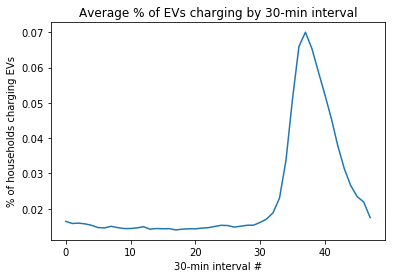

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(intervals, half_hour_avg_charging)
plt.title('Average % of EVs charging by 30-min interval')
plt.ylabel('% of households charging EVs')
plt.xlabel('30-min interval #')

Safe to say people like to chage their cars at a certain time of the day. Let's throw up a plot over all the intervals to see if there are any other trends to exploe.

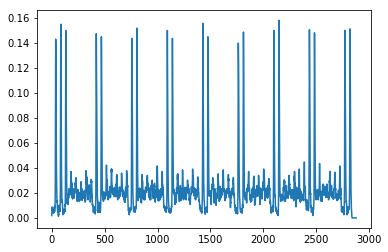

In [151]:
plt.plot(range(0,2880), perc_homes_charing_by_interval)

Some big spikes, maybe day of the week?

In [152]:
def chunk_it(seq, num):
  avg = len(seq) / float(num)
  out = []
  last = 0.0

  while last < len(seq):
    day = seq[int(last):int(last + avg)]
    day_avg = sum(day)/len(day)
    out.append(day_avg)
    last += avg

  return out

In [153]:
daily_avg = chunk_it(perc_homes_charing_by_interval, 60)

In [154]:
intervals = range(0,7)  # 48 half hour intervals in a day
dow_avg = []
for i in intervals:
    inter = daily_avg[i::7]
    dow_avg.append(sum(inter)/len(inter))

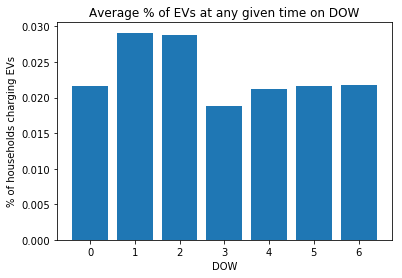

In [155]:
plt.bar(intervals, dow_avg)
plt.title('Average % of EVs at any given time on DOW')
plt.ylabel('% of households charging EVs')
plt.xlabel('DOW')